In [1]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from helpers import SemiSupervisedDataset
from helpers import train, evaluation, generate_confusion_matrix
from helpers import plot_accuracy, plot_loss, plot_confusion_matrix

In [2]:
DATA_PATH = './15SceneData/'
MODELS_PATH = './models/'
PLOTS_PATH = './plots/'
MODEL_NAME = 'rotation_v1'

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

NUM_CLASSES = 4
BATCH_SIZE = 32
NUM_EPOCHS = 30
PATIENCE = 5

# Load Data

In [3]:
# Load via custom function that returns rotated dataset of size 4x1500 --> rotate every image for times
train_dataset = SemiSupervisedDataset(
    DATA_PATH + 'train',
    image_transformation='rotation',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
)

val_dataset = SemiSupervisedDataset(
    DATA_PATH + 'validation',
    image_transformation='rotation',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])  
    ])
)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Change the classifier part of model to fit our problem
print('BEFORE:', model.classifier)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, NUM_CLASSES, bias=True)
)
print('AFTER:', model.classifier)

BEFORE: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
AFTER: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)


In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

fitted, train_loss, train_acc, val_loss,  val_acc = train(
    model, 
    optimizer,
    loss_fn,
    train_loader, 
    val_loader, 
    lr_scheduler=lr_scheduler,
    num_epochs=NUM_EPOCHS, 
    patience=PATIENCE, 
    device=DEVICE
    )

torch.save(fitted, MODELS_PATH + MODEL_NAME + '.pt')

Epoch [11/30]: 100%|██████████| 188/188 [01:10<00:00,  2.65it/s, train_acc=89.3, train_loss=0.283, val_acc=94.3, val_loss=0.169]


Epoch 00011: reducing learning rate of group 0 to 1.0000e-04.


Epoch [20/30]: 100%|██████████| 188/188 [01:11<00:00,  2.65it/s, train_acc=94.6, train_loss=0.15, val_acc=96, val_loss=0.128] 


Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.


Epoch [21/30]: 100%|██████████| 188/188 [01:11<00:00,  2.65it/s, train_acc=94.9, train_loss=0.14, val_acc=96, val_loss=0.127] 


Early stopping!


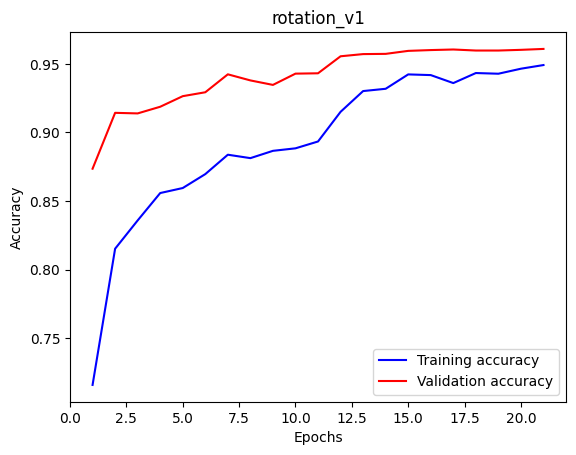

In [7]:
plot_accuracy(train_acc, val_acc, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_accuracy.png')

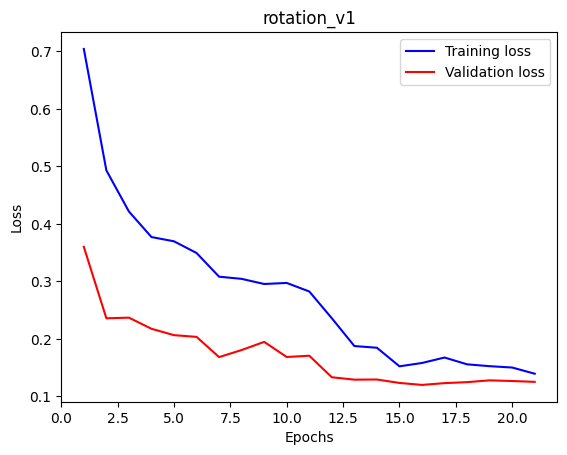

In [8]:
plot_loss(train_loss, val_loss, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_loss.png')

In [9]:
_, train_accuracy = evaluation(fitted, train_loader, nn.CrossEntropyLoss(), DEVICE)
_, val_accuracy = evaluation(fitted, val_loader, nn.CrossEntropyLoss(), DEVICE)

print(f'Train accuracy: {train_accuracy*100.:.2f}%')
print(f'Validation accuracy: {val_accuracy*100.:.2f}%')

Train accuracy: 95.65%
Validation accuracy: 96.01%


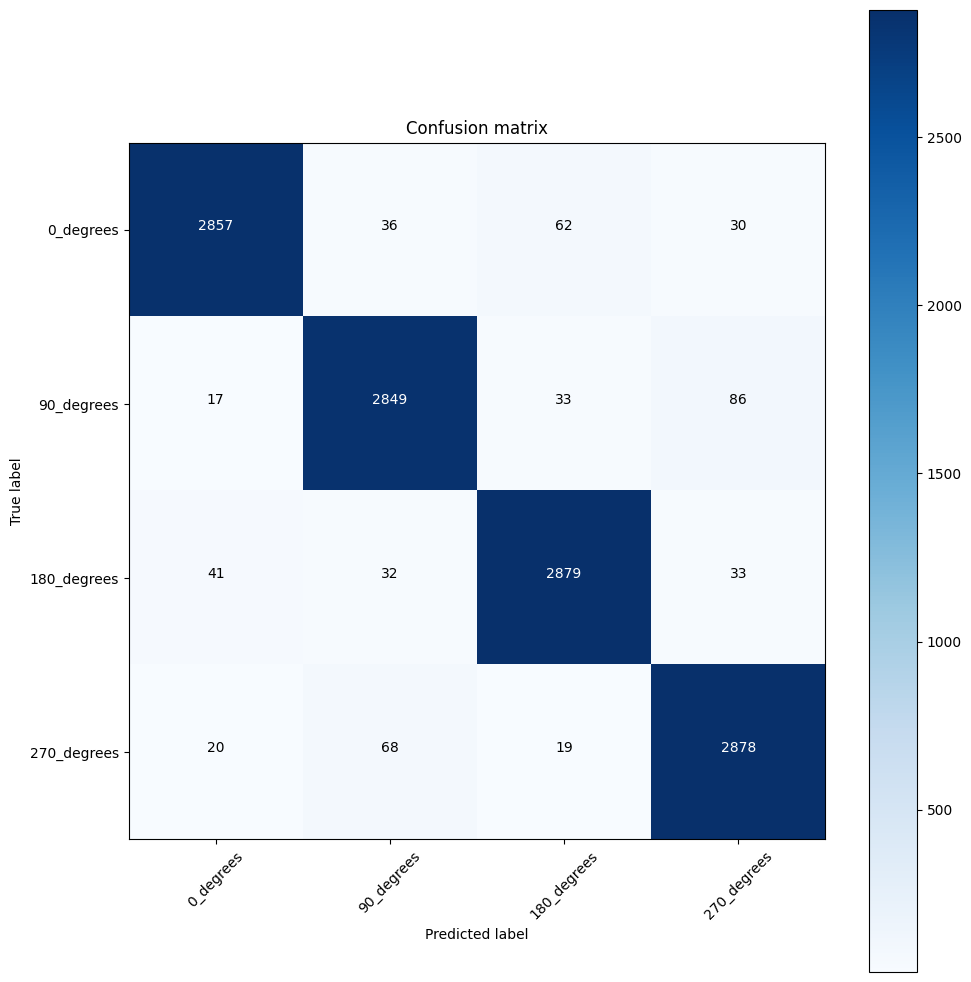

In [10]:
cm = generate_confusion_matrix(fitted, val_loader, DEVICE)

plot_confusion_matrix(
    cm,
    val_loader.dataset.classes,
    'Confusion matrix',
    PLOTS_PATH + MODEL_NAME + '_confusion_matrix.png',
    normalize=False
)